In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cvxopt

import pickle

# Variable saving.


def pickleSave(var, filename='.pickle'):
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(var, f)
    print('PickleSave Succeeded.')
    return

# Variable loading.


def pickleLoad(filename):
    """
    Make sure it's assigned to a variable.
    """
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'rb') as f:
        cache = pickle.load(f)
    print("PickleLoad Succeeded. Make sure it's assigned to a variable.")
    return cache


In [2]:
def conjGrad(A, b, maxIter=-1, x="0", eps=1e-6, showChangeRate=False):
    """
    迭代的共轭梯度法. 要求A实正定对称.
    `x`:初始点.
    收敛相对误差|Δx[t]|/|x[t-1]|被`eps`控制.
    方法优点: 迭代至多进行k=len(b)次. A事先计算出,控制迭代次数,则复杂度O(k^2).
    不吝啬迭代则O(k^3).
    """
    k = A.shape[0]  # 行/列数。
    if maxIter == -1:
        maxIter = k
    if x == '0':
        x = np.zeros(k)
    r = b - np.dot(A, x)
    p = r
    r2old = r.dot(r)
    for i in range(maxIter):
        Ap = A.dot(p)
        alpha = r2old / (p.dot(Ap))
        xOld = x
        x = x + alpha * p
        r = r - alpha * Ap
        r2new = r.dot(r)
        changeRate = np.sqrt((x-xOld).dot(x-xOld)/(eps**2 + x.dot(x)))
        # 相对迭代误差(改进率).
        if showChangeRate:
            print('Iter', i, ':', changeRate)
        if changeRate < eps:
            break
        p = r + (r2new/r2old)*p
        r2old = r2new
    return x


In [3]:
# LSCSresidualStatic
def LSCSResidualStatic(y: np.ndarray, Phi: np.ndarray, T0=[],
                       lamb=1e-1, alpha=0.05, alphaDel=0.05,
                       conjGradIter=-1):
    """
    Return (xEsti, T_Esti).
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x0 = np.zeros(n)  # x_init
    x0[T0] = conjGrad(Phi[:, T0].T.dot(Phi[:, T0]), Phi[:, T0].T.dot(y))
    yRes = y - Phi.dot(x0)  # LS-residual y_res
    # Variables for LP:
    c = cvxopt.matrix(np.ones(2*n), (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    dRes = Phi.T.dot(yRes)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  dRes + lamb*np.ones(n),
                  -dRes + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x0 += xsol  # x_CSres
    # Detect:
    Tdet = list(set(T0) | set(np.arange(n)[np.abs(x0) > alpha]))
    x0 = np.zeros(n)
    x0[Tdet] = conjGrad(Phi[:, Tdet].T.dot(
        Phi[:, Tdet]), Phi[:, Tdet].T.dot(y))
    # x_det
    # Delete:
    Tt = list(set(Tdet) - set(np.arange(n)[np.abs(x0) <= alphaDel]))
    x0 = np.zeros(n)  # x_final
    x0[Tt] = conjGrad(Phi[:, Tt].T.dot(Phi[:, Tt]), Phi[:, Tt].T.dot(y), conjGradIter)

    return (x0, Tt)


In [18]:
X = pickleLoad('X.pickle')
sampMats = pickleLoad('sampMats.pickle')
Supps = pickleLoad('Supps.pickle')



PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


预试验

In [5]:
# Rademacher(1,-1,Prob=0.5) on support.
def randSparseSignal(n=2000, s=50, size=10000, returnSupports=False, allowLowerSparsity=False):
    """
    Generate `size` number of signals of dimension `n` and sparsity `s`.
    Aranged by columns.

    If `returnSupports`=`True` then also return Supports of Signals aranged by columns,
    repetitions might be included.
    """
    size = int(size)  # 转化形如`1e5`的输入.
    V = np.zeros((n, size), order='F', dtype=np.float32)
    Supps = np.array([np.random.choice(
        range(n), s, replace=allowLowerSparsity) for _ in range(size)])
    # 随机抽取支集, 存为每一行.
    Entries = np.array(
        [np.random.binomial(1, 0.5, s).astype(np.float32)*2-1 for _ in range(size)])
    # 随机赋予支集项的值, 存为每一行.
    for j in range(size):
        V[Supps[j], j] = Entries[j]
    if returnSupports == True:
        return dict(
            Signals=V,
            Supports=Supps.T
        )
    else:
        return V


In [6]:
# Generate random Sparse signal Time Sequence(STS): Markov random walking model
# Basic amplitude of one component: 1.0
def randSTS(n=2000, N=10, s=50, sigma=0.1):
    '''
    description: `sigma`: walking deviance. `N`: time length. `s`: initial sparsity. `n`: signal dimension.
    return `STS` aranged by cols.
    '''    
    x0 = randSparseSignal(n,s,size=1)[:,0]
    STS = np.zeros((n,N))
    STS[:,0] = x0
    for t in range(1,N):
        TNew = np.random.choice(np.arange(n),s//5,False)
        walk = np.zeros(n)
        walk[TNew] = np.random.normal(0,sigma,len(TNew))
        x1 = x0 + walk
        STS[:,t] = x1
        x0 = x1
    return STS


In [11]:
# np.random.seed(42)
# STS = randSTS()
# pickleSave(STS,'STS')

PickleSave Succeeded.


In [19]:
STS = pickleLoad('STS')
STS.shape

PickleLoad Succeeded. Make sure it's assigned to a variable.


(2000, 10)

In [7]:
def getSupp(x: np.ndarray, s: int = -1):
    """
    Return supp(x_s) corresponding to from Largest to Smallest. \n
    If `s` left default, -1, then s=sum(x!=0).
    """
    if s == -1:
        s = sum(1 - np.isclose(x, 0))
    return np.abs(x).argsort()[:-s-1:-1]


LSCS

In [8]:
# LSCSresidual
def LSCSResidual(Y: np.ndarray, Phi: np.ndarray, x0: np.ndarray, T0=[],
                 lamb=1e-1, alpha=0.05, alphaDel=0.05,
                 conjGradIter=-1,
                 ):
    """
    Return signal sequence reconstruction for observed `Y`.
    """
    if T0 == []:
        T0 = list(getSupp(x0))
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    X = np.zeros((n, N))
    for t in range(N):
        X[:, t], T0 = LSCSResidualStatic(
            Y[:, t], Phi, T0, lamb, alpha, alphaDel, conjGradIter)
    print('LSCSresidual Succeeded.')
    return X


In [20]:
XTS = []
for Phi in sampMats:
    XTS.append(LSCSResidual(Phi @ STS, Phi, STS[:,0]))

     pcost       dcost       gap    pres   dres   k/t
 0:  3.7422e-21 -4.0000e+02  1e+04  1e+01  1e+00  1e+00
 1: -1.1254e+02 -1.4182e+02  4e+02  1e+00  8e-02  8e-01
 2: -5.2880e+00 -5.9350e+00  7e+00  2e-02  2e-03  2e-02
 3: -5.2154e-02 -5.8551e-02  7e-02  2e-04  2e-05  2e-04
 4: -5.2147e-04 -5.8543e-04  7e-04  2e-06  2e-07  2e-06
 5: -5.2147e-06 -5.8543e-06  7e-06  2e-08  2e-09  2e-08
 6: -5.2147e-08 -5.8543e-08  7e-08  2e-10  2e-11  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -6.8085e-16 -4.0000e+02  1e+04  1e+01  1e+00  1e+00
 1: -1.1296e+02 -1.4223e+02  5e+02  1e+00  8e-02  8e-01
 2: -1.3277e+01 -1.6161e+01  3e+01  1e-01  7e-03  8e-02
 3: -3.8213e+00 -4.6525e+00  9e+00  3e-02  2e-03  2e-02
 4: -3.5850e+00 -4.3743e+00  9e+00  3e-02  2e-03  2e-02
 5: -1.2080e+00 -1.4864e+00  3e+00  1e-02  7e-04  4e-04
 6: -1.0024e-01 -1.2728e-01  3e-01  9e-04  7e-05  4e-05
 7:  1.7570e-02  1.7296e-02  3e-03  1e-05  7e-07  4e-07
 8:  1.8764e-02  1.8761e-02 

In [23]:
# pickleSave(XTS,'XTS_m_LSCSResidual')

PickleSave Succeeded.


PickleLoad Succeeded. Make sure it's assigned to a variable.


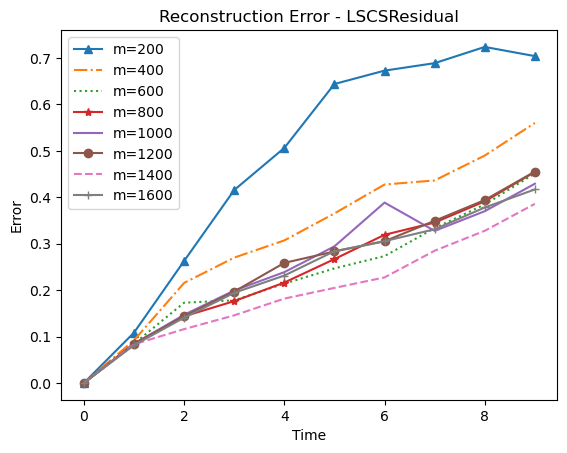

In [38]:
XTS_m_LSCSResidual = pickleLoad('XTS_m_LSCSResidual')

errs = []
for m in range(len(sampMats)):
    errs.append(np.sum((XTS_m_LSCSResidual[m] - STS)**2,0))

styles = ['^-','-.',':','*-',',-','-o','--','+-']

numMeasurements = np.arange(200,1601,200)
for m in range(len(numMeasurements)):
    plt.plot(np.arange(0,10),errs[m],styles[m],label='m='+str(numMeasurements[m]))
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Reconstruction Error - LSCSResidual')
plt.legend()
plt.show()

KFCS

In [47]:
# KFCSresidualStatic
def KFCSResidualStatic(y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
                       P0=None, sigma2Sys=0.01, sigma2=0.01, lamb=0.1,
                       alpha=0.05, alphaDel=0.15,
                       ):
    """
    Return (xEsti, P_Esti, T_Esti).
    """
    m, n = Phi.shape
    if x0 is None:
        x0 = np.zeros(n)
    if P0 is None:
        P0 = np.zeros((n, n))
    T0 = list(T0)
    Q = np.zeros((n, n))

    temp = Q[T0,:]
    temp[:,T0] = sigma2Sys * np.identity(len(T0))
    Q[T0,:] = temp
    P10 = P0 + Q

    # P10[T0,T0] is non-zero
    K = np.zeros((n, m))
    K[T0, :] = P10[T0, T0].dot((Phi[:, T0].T)).dot(np.linalg.inv(
        (Phi[:, T0].dot(P10[T0,:][:, T0]).dot((Phi[:, T0].T))) + sigma2 * np.identity(m)))
    # O(m^3)
    # K[T0,:] is non-zero.
    # P[T0,T0] is nonzero.
    P = np.zeros((n, n))

    temp = P[T0,:]
    temp[:,T0] = (np.identity(len(T0)) - K[T0, :] @ Phi[:, T0]) @ P10[T0,:][:, T0]
    P[T0,:] = temp

    x = np.zeros(n)
    x[T0] = (np.identity(len(T0)) - K[T0, :] @ Phi[:, T0]
             ) @ x0[T0] + K[T0, :] @ y  # x_init
    yRes = y - Phi[:, T0] @ x[T0]  # yRes

    # Variables for LP:
    c = cvxopt.matrix(np.ones(2*n), (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    dRes = Phi.T.dot(yRes)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  dRes + lamb*np.ones(n),
                  -dRes + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x += xsol  # x_CSres

    # Detect:
    Tdet = list(set(T0) | set(np.arange(n)[np.abs(x) > alpha]))
    if set(Tdet) == set(T0):
        pass
    else:
        x = np.zeros(n)
        x[Tdet] = conjGrad(Phi[:, Tdet].T.dot(
            Phi[:, Tdet]), Phi[:, Tdet].T.dot(y))
        # x_det
    # Delete:
    Tt = list(set(Tdet) - set(np.arange(n)[np.abs(x) <= alphaDel]))
    if set(Tt) == set(T0):
        P1 = P0
    else:
        x = np.zeros(n)  # x_final
        x[Tt] = conjGrad(Phi[:, Tt].T.dot(Phi[:, Tt]), Phi[:, Tt].T.dot(y))
        P1 = np.zeros((n, n))
        temp = P1[Tt,:]
        temp[:, Tt] = sigma2 * np.linalg.inv(Phi[:, Tt].T @ Phi[:, Tt])
        P1[Tt,:] = temp
    return (x, P1, Tt)


In [45]:
def KFCSResidual(Y: np.ndarray, Phi: np.ndarray, x0: np.ndarray,
                 T0=[],
                 P0=None, sigma2Sys=0.01, sigma2=0.01, lamb=0.1,
                 alpha=0.05, alphaDel=0.15,):
    """
    Return signal sequence reconstruction for observed `Y`.
    """
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = np.array(getSupp(x0))
    if P0 is None:
        P0 = np.zeros((n, n))
        temp = P0[T0,:]
        temp[:,T0] = sigma2 * np.linalg.inv(Phi[:, T0].T @ Phi[:, T0])
        P0[T0,:] = temp
    X = np.zeros((n, N))
    for t in range(N):
        x0, P0, T0 = KFCSResidualStatic(
            Y[:, t], Phi, x0, T0, P0, sigma2Sys, sigma2, lamb, alpha, alphaDel)
        X[:, t] = x0
    print('KFCSresidual Succeeded.')
    return X


In [48]:
# XTS = []
# for Phi in sampMats:
#     XTS.append(KFCSResidual(Phi @ STS, Phi, STS[:,0], sigma2Sys=0.1, alphaDel=0.05))

# pickleSave(XTS,'XTS_m_KFCSResidual')

     pcost       dcost       gap    pres   dres   k/t
 0:  5.2039e-28 -4.0000e+02  1e+04  1e+01  1e+00  1e+00
 1: -1.1254e+02 -1.4182e+02  4e+02  1e+00  8e-02  8e-01
 2: -5.2879e+00 -5.9349e+00  7e+00  2e-02  2e-03  2e-02
 3: -5.2152e-02 -5.8549e-02  7e-02  2e-04  2e-05  2e-04
 4: -5.2145e-04 -5.8541e-04  7e-04  2e-06  2e-07  2e-06
 5: -5.2145e-06 -5.8541e-06  7e-06  2e-08  2e-09  2e-08
 6: -5.2145e-08 -5.8541e-08  7e-08  2e-10  2e-11  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.6230e-14 -4.0000e+02  1e+04  9e+00  1e+00  1e+00
 1: -1.1368e+02 -1.4291e+02  5e+02  7e-01  7e-02  8e-01
 2: -2.7292e+01 -3.5613e+01  1e+02  2e-01  2e-02  2e-01
 3: -1.1679e+01 -1.6177e+01  5e+01  1e-01  1e-02  3e-02
 4: -4.7796e+00 -7.3192e+00  3e+01  6e-02  6e-03  1e-02
 5: -6.9550e-02 -1.3200e+00  1e+01  3e-02  3e-03  6e-03
 6:  2.2899e+00  1.6526e+00  7e+00  1e-02  2e-03  2e-03
 7:  3.5610e+00  3.2402e+00  4e+00  7e-03  8e-04  9e-04
 8:  4.3656e+00  4.2380e+00 

PickleLoad Succeeded. Make sure it's assigned to a variable.


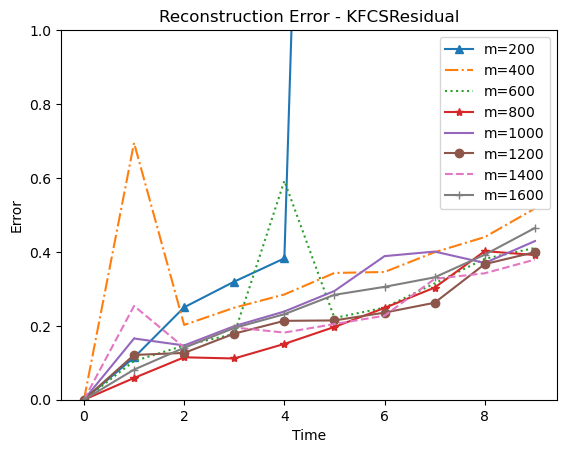

In [52]:
XTS_m_KFCSResidual = pickleLoad('XTS_m_KFCSResidual')

errs = []
for m in range(len(sampMats)):
    errs.append(np.sum((XTS_m_KFCSResidual[m] - STS)**2,0))

styles = ['^-','-.',':','*-',',-','-o','--','+-']

numMeasurements = np.arange(200,1601,200)
for m in range(len(numMeasurements)):
    plt.plot(np.arange(0,10),errs[m],styles[m],label='m='+str(numMeasurements[m]))
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Reconstruction Error - KFCSResidual')
plt.ylim(0,1)
plt.legend()
plt.show()

DRegModBPDN

In [53]:
# regModBPDN
def regModBPDN(y: np.ndarray, Phi: np.ndarray, T0=[],
               x0=None, gamma=1., lamb=1.):
    """
    Return xEsti. \n
    Params: \n
        min `gamma`*|x[T0^c]|(l1) + \n
            0.5|y-Phi@x|(l2)^2 + \n
            0.5*`lamb`*|x[T0]-`x0`[T0]|(l2)^2.
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x = np.zeros(n)
    if x0 is None:  # Degenerate to mod-MPDN.
        x0 = np.zeros(n)
        lamb = 1e-12

    # Variables for Quadratic Program:
    posNeg = np.block([[np.identity(n), -np.identity(n)]])
    oneT0 = np.zeros(n)
    oneT0[T0] = 1
    diagT0 = np.diag(oneT0)
    P = posNeg.T @ (lamb * diagT0 + Phi.T @ Phi) @ posNeg
    P = cvxopt.matrix(P, (2*n, 2*n), 'd')
    oneT0c = np.ones(n)
    oneT0c[T0] = 0
    oneOneT0c = np.append(oneT0c, oneT0c)
    q = gamma * oneOneT0c - posNeg.T @ Phi.T @ y - lamb * posNeg.T @ diagT0 @ x0
    q = cvxopt.matrix(q, (2*n, 1), 'd')
    G = -np.identity(2*n)
    G = cvxopt.matrix(G, (2*n, 2*n), 'd')
    h = np.zeros(2*n)
    h = cvxopt.matrix(h, (2*n, 1), 'd')

    xsol = cvxopt.solvers.qp(P, q, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x

def dynamicRegModBPDNStatic(
        y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
        gamma=1., lamb=1., alpha=0.1):
    '''
    return (xEsti, TEsti). \n
    `alpha`: Detection param.
    '''
    n = Phi.shape[1]
    x = regModBPDN(y, Phi, T0, x0, gamma, lamb)
    # Simple supp detection:
    Tt = np.arange(n)[np.abs(x) > alpha]

    return (x, Tt)

def dynamicRegModBPDN(
    Y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
    gamma=1., lamb=1., alpha=0.1
):
    '''
    Return signal sequence reconstruction for observed `Y`. \n
    `alpha`: Simple detection param.
    '''
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = list(getSupp(x0))
    X = np.zeros((n, N))
    for t in range(N):
        x0, T0 = dynamicRegModBPDNStatic(
            Y[:, t], Phi, x0, T0, gamma, lamb, alpha)
        X[:, t] = x0
    print('DynamicRegModBPDN Succeeded.')
    return X


In [63]:
# XTS = []
# for Phi in sampMats:
#     XTS.append(dynamicRegModBPDN(Phi @ STS, Phi, STS[:,0]))

# pickleSave(XTS,'XTS_m_dynamicRegModBPDN')


     pcost       dcost       gap    pres   dres
 0: -3.9491e+03  5.2063e+03  1e+04  1e+02  1e+00
 1:  1.2476e+03 -9.2264e+01  2e+03  3e+00  2e-02
 2: -3.7491e+01 -5.1715e+01  2e+01  3e-02  2e-04
 3: -5.1518e+01 -5.1661e+01  2e-01  3e-04  2e-06
 4: -5.1659e+01 -5.1661e+01  2e-03  3e-06  2e-08
 5: -5.1661e+01 -5.1661e+01  2e-05  3e-08  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.9493e+03  5.2062e+03  1e+04  1e+02  1e+00
 1:  1.2467e+03 -9.2653e+01  2e+03  3e+00  2e-02
 2: -2.0375e+01 -5.2045e+01  4e+01  6e-02  6e-04
 3: -5.1405e+01 -5.1891e+01  5e-01  9e-04  8e-06
 4: -5.1885e+01 -5.1890e+01  5e-03  9e-06  8e-08
 5: -5.1890e+01 -5.1890e+01  5e-05  9e-08  8e-10
 6: -5.1890e+01 -5.1890e+01  5e-07  9e-10  8e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.9496e+03  5.2192e+03  1e+04  1e+02  1e+00
 1:  1.2500e+03 -9.3369e+01  2e+03  3e+00  2e-02
 2: -1.9407e+01 -5.2281e+01  4e+01  6e-02  6e-04
 3: -5.1531e+01 -5.2097e

In [67]:
XTS_m_dynamicRegModBPDN = pickleLoad('XTS_m_dynamicRegModBPDN')


PickleLoad Succeeded. Make sure it's assigned to a variable.


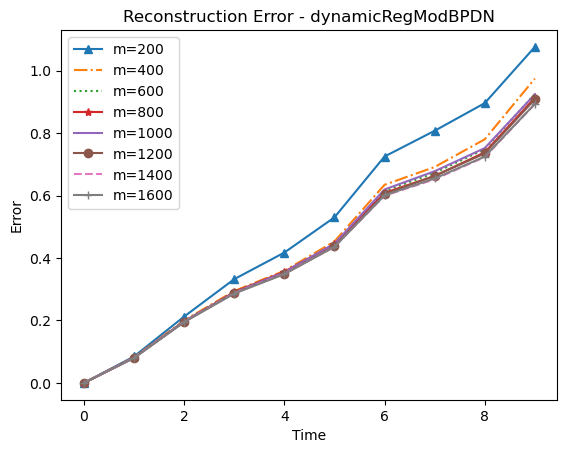

In [88]:

errs = []
for m in range(len(sampMats)):
    errs.append(np.sum((XTS_m_dynamicRegModBPDN[m] - STS)**2,0))

styles = ['^-','-.',':','*-',',-','-o','--','+-']

numMeasurements = np.arange(200,1601,200)
for m in range(len(numMeasurements)):
    plt.plot(np.arange(0,10),errs[m],styles[m],label='m='+str(numMeasurements[m]))
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Reconstruction Error - dynamicRegModBPDN')
plt.legend()
plt.show()

ModBPDNRes

In [61]:
def modBPDNResidualStatic(
        y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
        alpha=0.1
):
    '''
    return (xEsti, TEsti). \n
    `alpha`: Simple detection threshold.
    '''
    n = Phi.shape[1]
    if x0 is None:
        x0 = np.zeros(n)
    yRes = y - Phi @ x0
    xRes = regModBPDN(yRes, Phi, T0, gamma=0.0001)
    x = x0 + xRes
    # Simple detection:
    Tt = np.arange(n)[np.abs(x) > alpha]

    return (x, Tt)

def modBPDNResidual(Y:np.ndarray, Phi:np.ndarray, x0=None,
                    T0=[], alpha=0.1):
    '''
    `alpha`: Detection param. \n 
    return signal sequence reconstruction from observed `Y`.
    '''
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = list(getSupp(x0))
    X = np.zeros((n, N))
    for t in range(N):
        x0, T0 = modBPDNResidualStatic(
            Y[:, t], Phi, x0, T0, alpha)
        X[:, t] = x0
    print('ModBPDNResidual Succeeded.')
    return X
    

In [ ]:
# XTS = []
# for Phi in sampMats:
#     XTS.append(modBPDNResidual(Phi @ STS, Phi, STS[:,0], getSupp(STS[:,0])))

# pickleSave(XTS,'XTS_m_modBPDNResidual')


In [69]:
XTS_m_modBPDNResidual = pickleLoad('XTS_m_modBPDNResidual')


PickleLoad Succeeded. Make sure it's assigned to a variable.


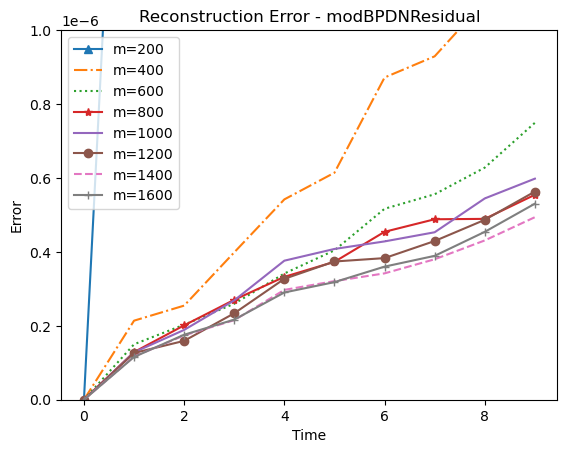

In [99]:

errs = []
for m in range(len(sampMats)):
    errs.append(np.sum((XTS_m_modBPDNResidual[m] - STS)**2,0))

styles = ['^-','-.',':','*-',',-','-o','--','+-']

numMeasurements = np.arange(200,1601,200)
for m in range(len(numMeasurements)):
    plt.plot(np.arange(0,10),errs[m],styles[m],label='m='+str(numMeasurements[m]))
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Reconstruction Error - modBPDNResidual')
plt.legend()
plt.ylim(0,1e-6)
plt.show()